In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import plotly.graph_objects as go
import umap
import umap.plot

2024-09-18 16:57:36.618513: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/tom/anaconda3/lib/python3.11/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:
# Load ECG dataset
dataframe = pd.read_csv('ecg.csv', header=None)
raw_data = dataframe.values

In [3]:
print(dataframe.head())

        0         1         2         3         4         5         6    \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        7         8         9    ...       131       132       133       134  \
0 -1.818286 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

        135       136       137       138       139  140  
0  0.2577

In [4]:
# Verifiying the shape
raw_data.shape

(4998, 141)

In [5]:
# Verifying the distribution of the labels (0 is abnormal signal, 1 is normal signal)
# Get the counts of each unique value in the 141st column
label_counts = dataframe.iloc[:, 140].value_counts()

# Divide the counts by the total number of rows to get the proportions
label_proportions = label_counts / len(dataframe)

# Print the proportions
print(label_proportions)

140
1.0    0.584034
0.0    0.415966
Name: count, dtype: float64


In [6]:
# Splitting dataset
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [7]:
# Normalisation
min_val = np.min(train_data)
max_val = np.max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

# Convertion into pytorch tensor
train_data = torch.FloatTensor(train_data)
test_data = torch.FloatTensor(test_data)

# Convertion of the labels into boolean data type
train_labels = torch.BoolTensor(train_labels.astype(bool))
test_labels = torch.BoolTensor(test_labels.astype(bool))

# Separation between normal and abnormal signals
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [8]:
print("Length of train:", len(train_labels))
print("Length of test:", len(test_labels))

Length of train: 3998
Length of test: 1000


In [9]:
# Splitting dataset
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [10]:
# Normalisation
min_val = np.min(train_data)
max_val = np.max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = torch.FloatTensor(train_data)
test_data = torch.FloatTensor(test_data)

train_labels = torch.BoolTensor(train_labels.astype(bool))
test_labels = torch.BoolTensor(test_labels.astype(bool))

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [11]:
print("Length of train:", len(train_labels))
print("Length of test:", len(test_labels))

Length of train: 3998
Length of test: 1000


In [12]:
# Visualizing normal and abnormal ECG
def plot_ecg(data, title, color):
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=2)
    sns.set_style("white")
    plt.grid()
    plt.plot(np.arange(140), data, color=color, linewidth=3.0)
    plt.title(title)
    plt.show()

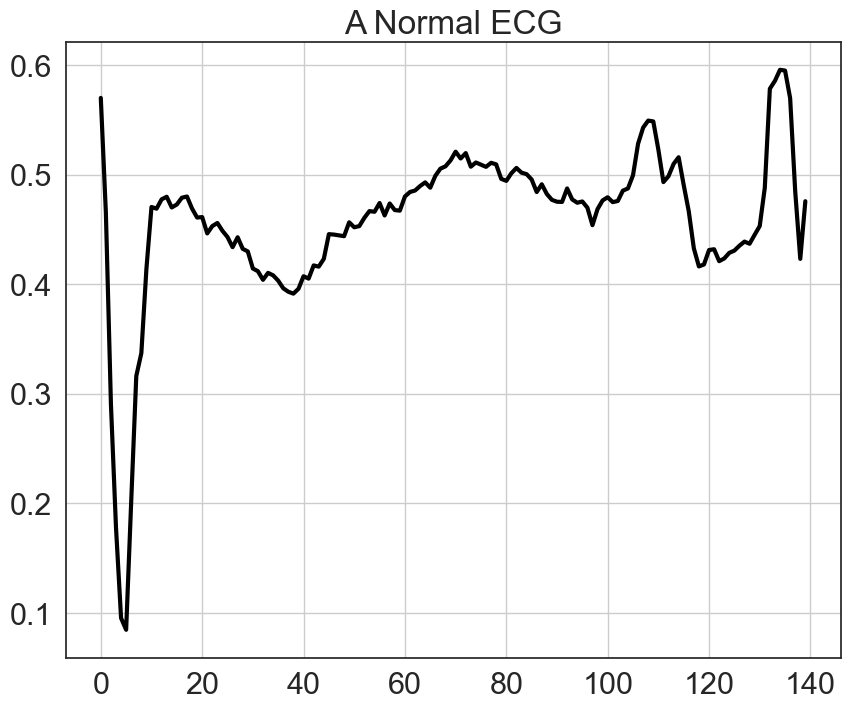

In [13]:
plot_ecg(normal_train_data[0], "A Normal ECG", "black")

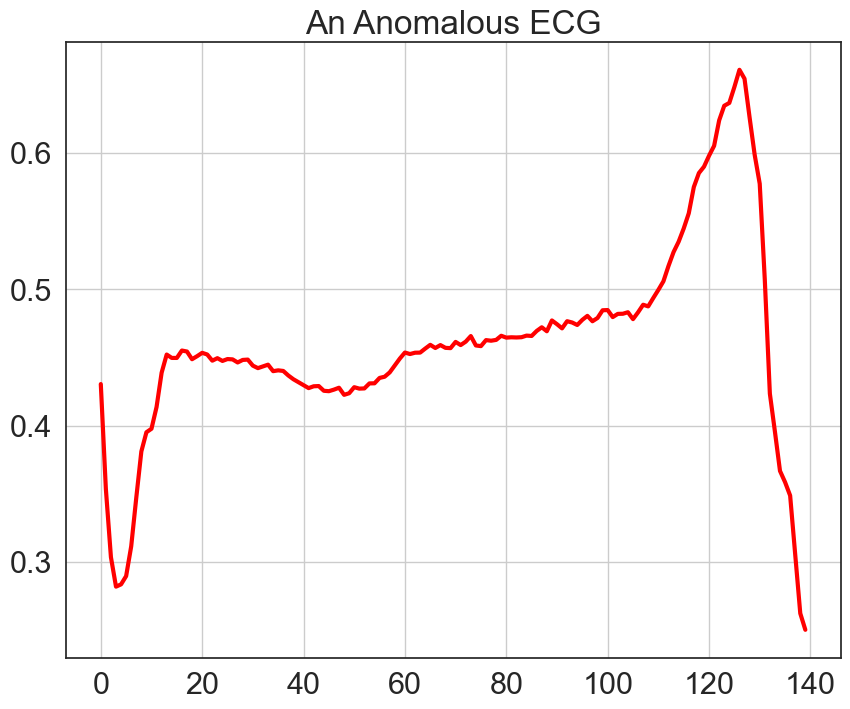

In [14]:
plot_ecg(anomalous_train_data[0], "An Anomalous ECG", "red")

In [15]:
# Auto encoder architecture
class AnomalyDetector(nn.Module):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(140, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 140),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [16]:
criterion = nn.L1Loss()  # MAE loss function
optimizer = optim.Adam(autoencoder.parameters()) # ADAM optimizer

In [17]:
# Training function
def train(model, train_data, num_epochs=20, batch_size=512):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

In [18]:
# Train on normal data
train(autoencoder, normal_train_data)

Epoch [1/20], Loss: 0.0629
Epoch [2/20], Loss: 0.0596
Epoch [3/20], Loss: 0.0566
Epoch [4/20], Loss: 0.0537
Epoch [5/20], Loss: 0.0506
Epoch [6/20], Loss: 0.0474
Epoch [7/20], Loss: 0.0440
Epoch [8/20], Loss: 0.0406
Epoch [9/20], Loss: 0.0378
Epoch [10/20], Loss: 0.0351
Epoch [11/20], Loss: 0.0325
Epoch [12/20], Loss: 0.0300
Epoch [13/20], Loss: 0.0280
Epoch [14/20], Loss: 0.0266
Epoch [15/20], Loss: 0.0255
Epoch [16/20], Loss: 0.0246
Epoch [17/20], Loss: 0.0238
Epoch [18/20], Loss: 0.0234
Epoch [19/20], Loss: 0.0230
Epoch [20/20], Loss: 0.0226


In [19]:
# Testing
def test(model, test_data):
    model.eval()
    with torch.no_grad():
        reconstructions = model(test_data)
    return reconstructions

normal_reconstructions = test(autoencoder, normal_test_data)
anomalous_reconstructions = test(autoencoder, anomalous_test_data)

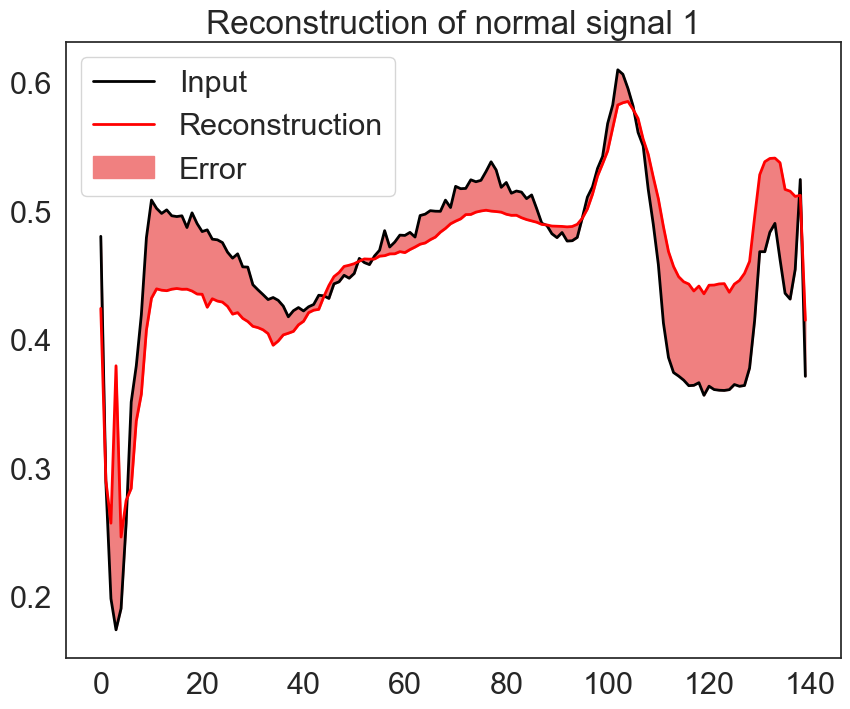

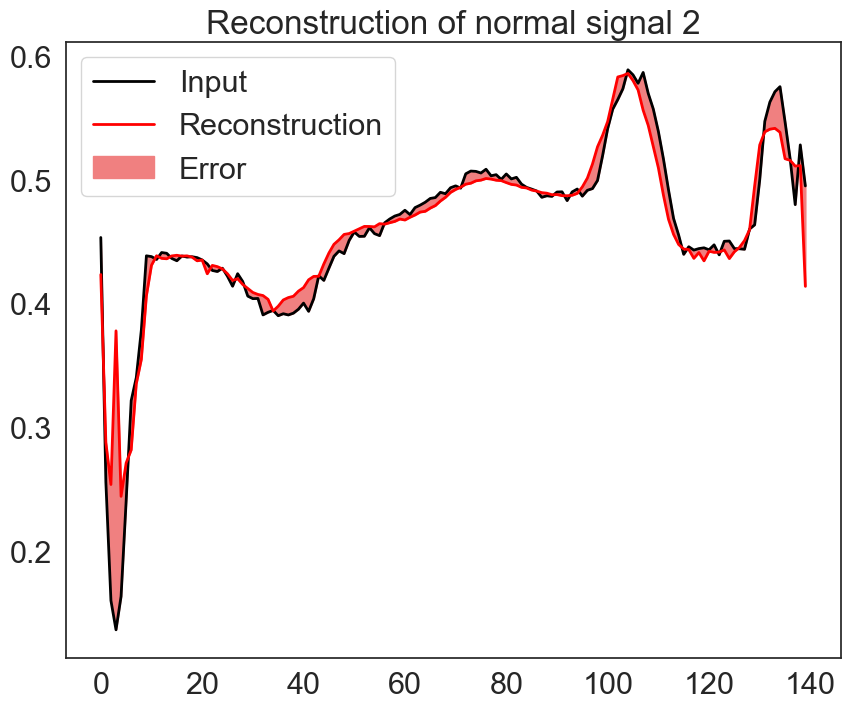

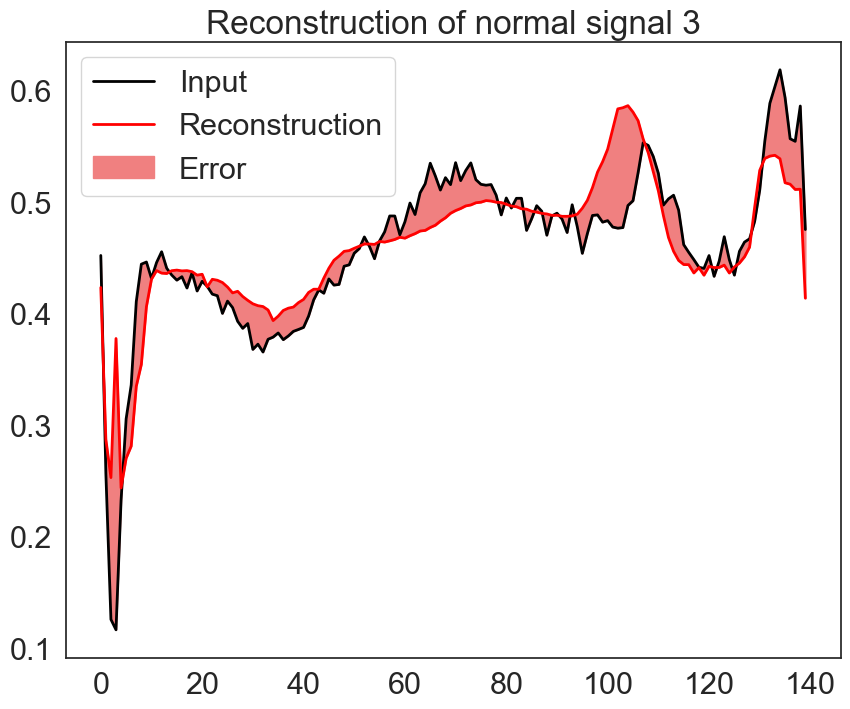

In [20]:
# Reconstructing normal signals
encoded_imgs = autoencoder.encoder(normal_test_data).detach().cpu().numpy()
decoded_imgs = autoencoder.decoder(torch.tensor(encoded_imgs).float()).detach().cpu().numpy()

for i in range(3):
    plt.figure(figsize=(10,8))
    sns.set(font_scale = 2)
    sns.set_style("white")
    plt.plot(normal_test_data[i].cpu().numpy(), 'black', linewidth=2)
    plt.plot(decoded_imgs[i], 'red', linewidth=2)
    plt.fill_between(np.arange(140), decoded_imgs[i], normal_test_data[i].cpu().numpy(), color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.title(f"Reconstruction of normal signal {i+1}")  # Add a title

    plt.show()

In [21]:
# Convert encoded images to DataFrame and add label
encoded_imgs_normal = pd.DataFrame(encoded_imgs)
encoded_imgs_normal['label'] = 1

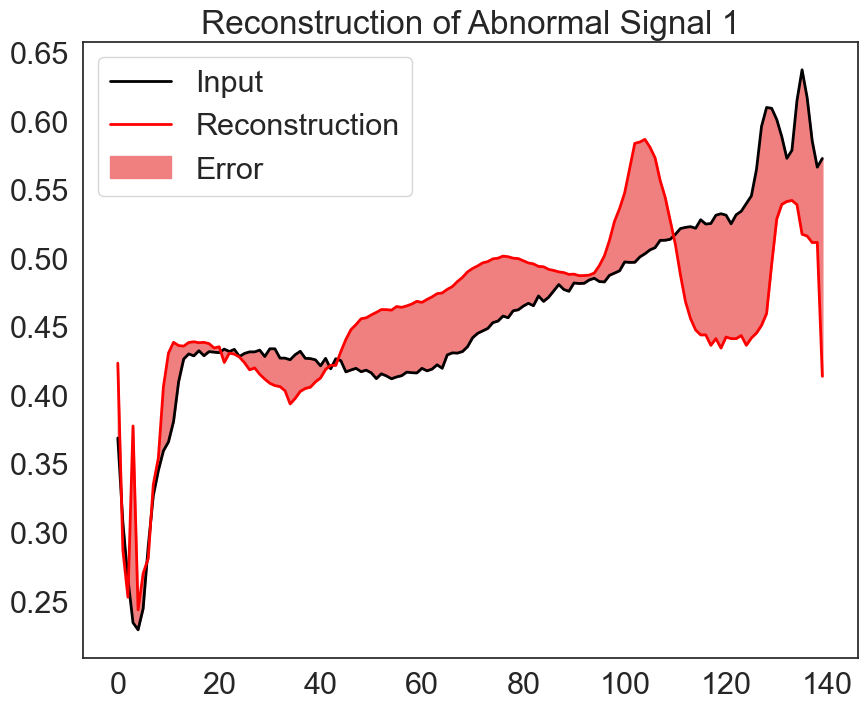

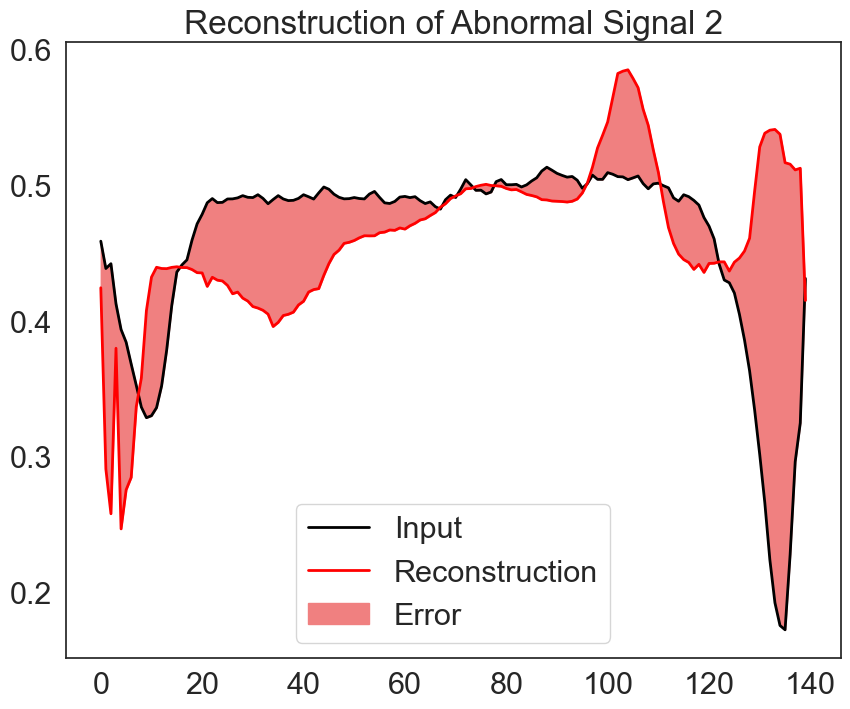

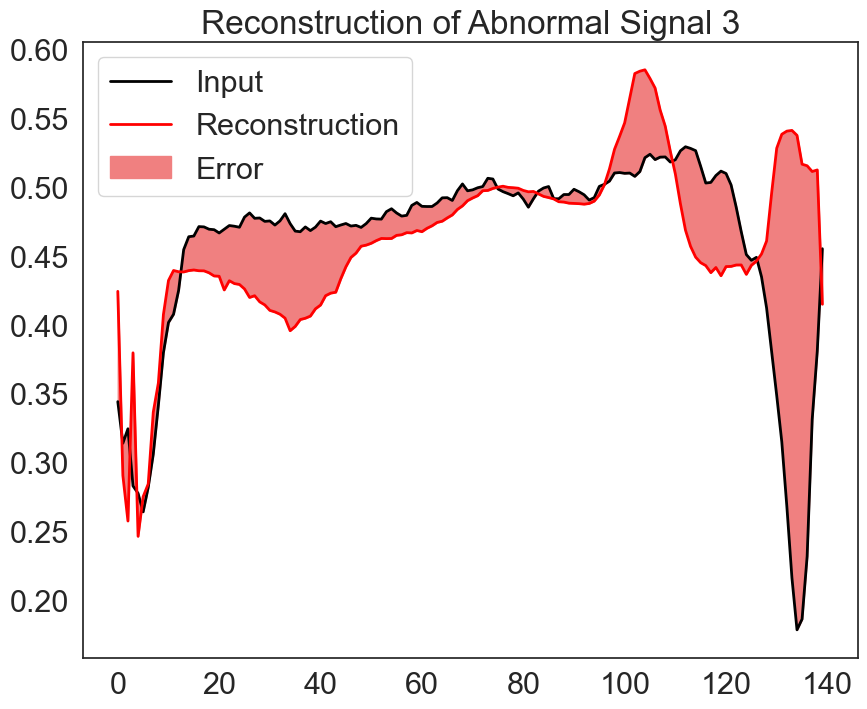

In [22]:
# Reconstructing abnormal signals
encoded_imgs = autoencoder.encoder(anomalous_test_data).detach().cpu().numpy()
decoded_imgs = autoencoder.decoder(torch.tensor(encoded_imgs).float()).detach().cpu().numpy()

for i in range(3):
    plt.figure(figsize=(10,8))
    sns.set(font_scale=2)
    sns.set_style("white")
    plt.plot(anomalous_test_data[i].cpu().numpy(), 'black', linewidth=2)
    plt.plot(decoded_imgs[i], 'red', linewidth=2)
    plt.fill_between(np.arange(140), decoded_imgs[i], anomalous_test_data[i].cpu().numpy(), color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.title(f"Reconstruction of Abnormal Signal {i+1}")  # Add a title
    plt.show()

In [23]:

# Convert encoded images to DataFrame and add label
encoded_imgs_abnormal = pd.DataFrame(encoded_imgs)
encoded_imgs_abnormal['label'] = 0

In [24]:
# Plotting the latent space of the autoencoder using UMAP : the normal and abnormal signals are clearly separated
all_encoded = pd.concat([encoded_imgs_normal,encoded_imgs_abnormal])

<Axes: >

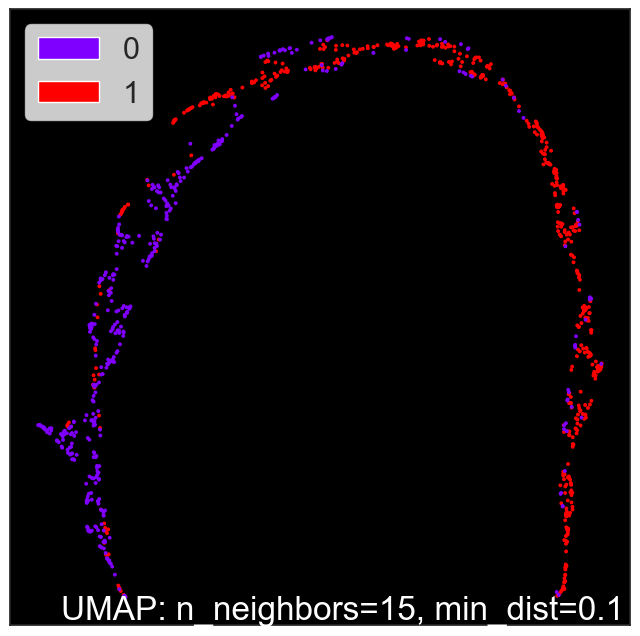

In [25]:
mapper = umap.UMAP().fit(all_encoded.iloc[:,:8])
umap.plot.points(mapper, labels=all_encoded.iloc[:,8], theme='fire')

In [26]:
# Calculate reconstructions using the PyTorch model
with torch.no_grad():
    reconstructions = autoencoder.decoder(autoencoder.encoder(normal_train_data)).cpu()

In [27]:
   
# Compute the Mean Absolute Error (MAE) as the reconstruction loss
loss_function = torch.nn.L1Loss(reduction='none')
train_loss = loss_function(reconstructions, normal_train_data).mean(dim=1).cpu().numpy()

In [28]:

# Calculate mean and standard deviation of train_loss
mean_loss = np.mean(train_loss)
std_loss = np.std(train_loss)

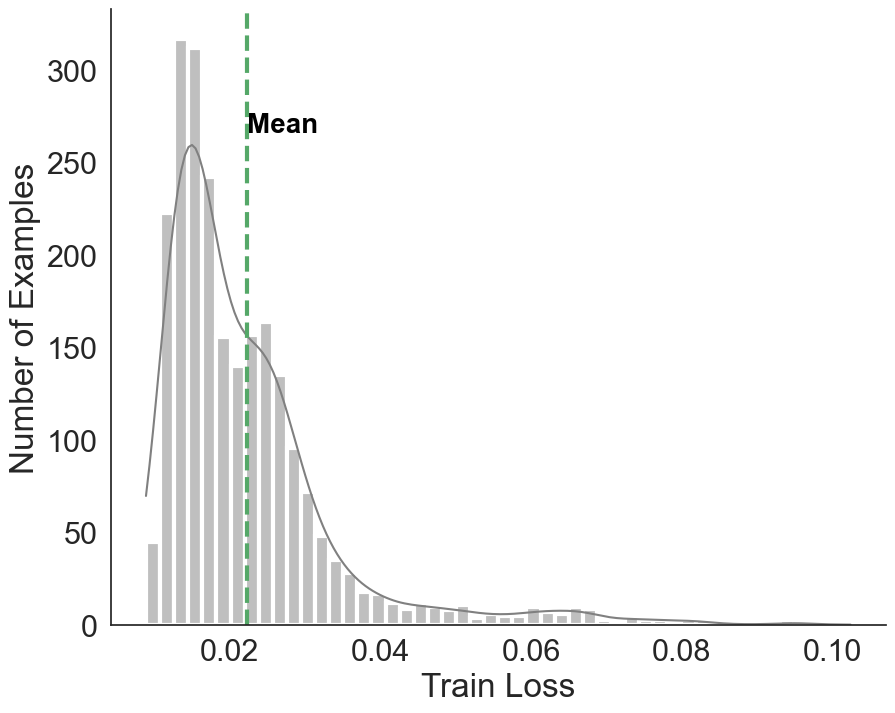

In [29]:

# Plotting the histogram of the reconstruction loss
plt.figure(figsize=(10,8))
sns.set(font_scale=2)
sns.set_style("white")
sns.histplot(train_loss, bins=50, kde=True, color='grey', linewidth=3)
plt.axvline(x=mean_loss, color='g', linestyle='--', linewidth=3)
plt.text(mean_loss, plt.ylim()[1] * 0.8, "Mean", horizontalalignment='left', 
         size='small', color='black', weight='semibold')
plt.xlabel("Train Loss")
plt.ylabel("Number of Examples")
sns.despine()
plt.show()

In [30]:
# We choose a threshold with a standard deviation higher than the mean.
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03454248


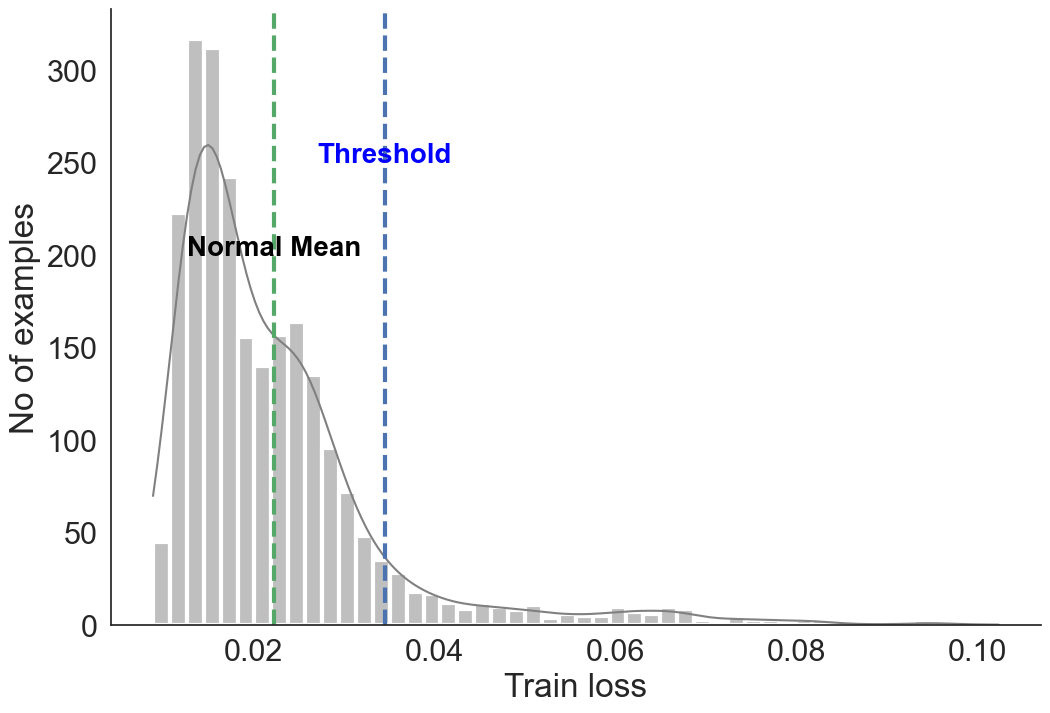

In [31]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()

In [32]:
# Calculate reconstructions for anomalous test data using the PyTorch model
with torch.no_grad():
    reconstructions_anomalous = autoencoder.decoder(autoencoder.encoder(anomalous_test_data)).cpu()

In [33]:
# Compute the Mean Absolute Error (MAE) as the reconstruction loss
loss_function = torch.nn.L1Loss(reduction='none')
test_loss = loss_function(reconstructions_anomalous, anomalous_test_data).mean(dim=1).cpu().numpy()

In [34]:
# Calculate mean and standard deviation of test_loss
mean_test_loss = np.mean(test_loss)

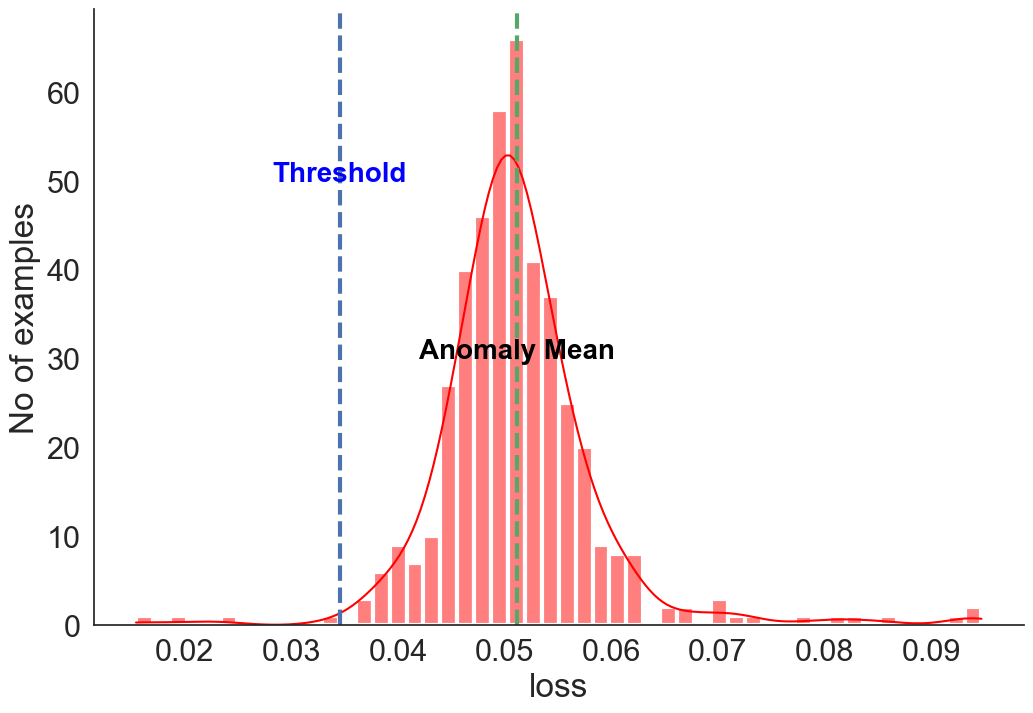

In [35]:
# Plotting the histogram of the reconstruction loss for anomalous test data
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 30, "Anomaly Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.text(threshold, 50, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

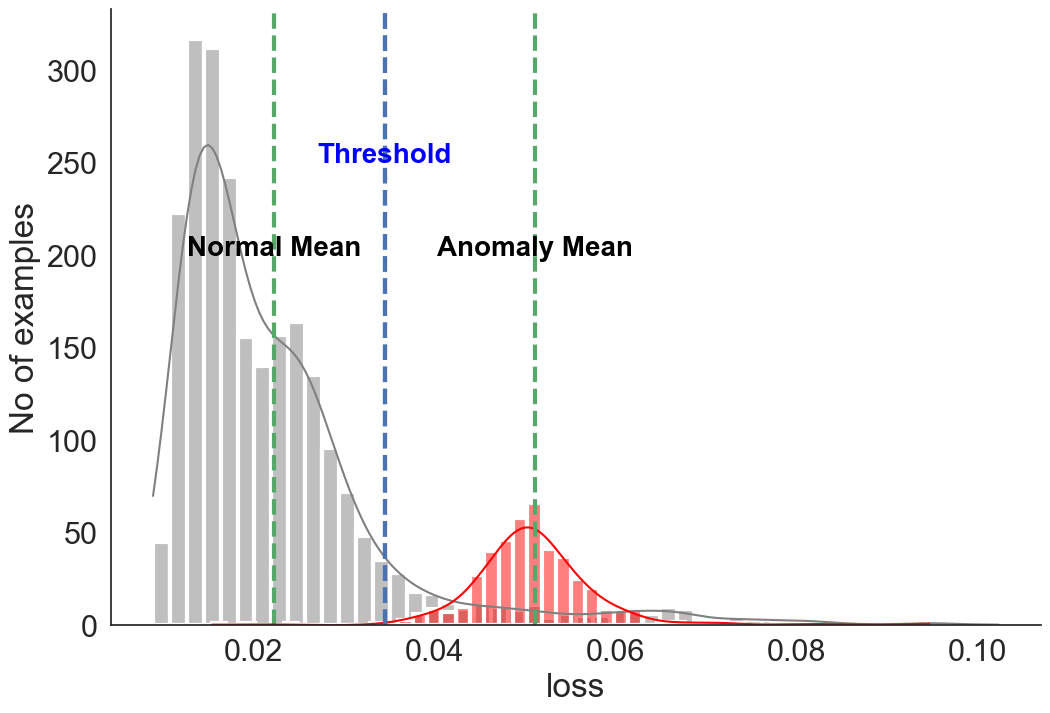

In [36]:
# Plotting histograms of the reconstruction loss for normal and abnormal data, as well as the threshold.
# The threshold helps to distinguish between normal and abnormal signals effectively.
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')

sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 200, "Anomaly Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

In [37]:
# Predicting anomalies and evaluating the performances
def predict(model, data, threshold):
    with torch.no_grad():
        reconstructions = model(data)
        # Compute the Mean Absolute Error (MAE) for each sample
        loss_function = torch.nn.L1Loss(reduction='none')
        loss = loss_function(reconstructions, data).mean(dim=1).cpu().numpy()
        # Return whether each loss is less than the threshold
        return loss < threshold

def print_stats(predictions, labels):
    print("Accuracy = {:.2f}".format(accuracy_score(labels, predictions)))
    print("Precision = {:.2f}".format(precision_score(labels, predictions)))
    print("Recall = {:.2f}".format(recall_score(labels, predictions)))

In [38]:
# Predict anomalies
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.95
Precision = 0.99
Recall = 0.91


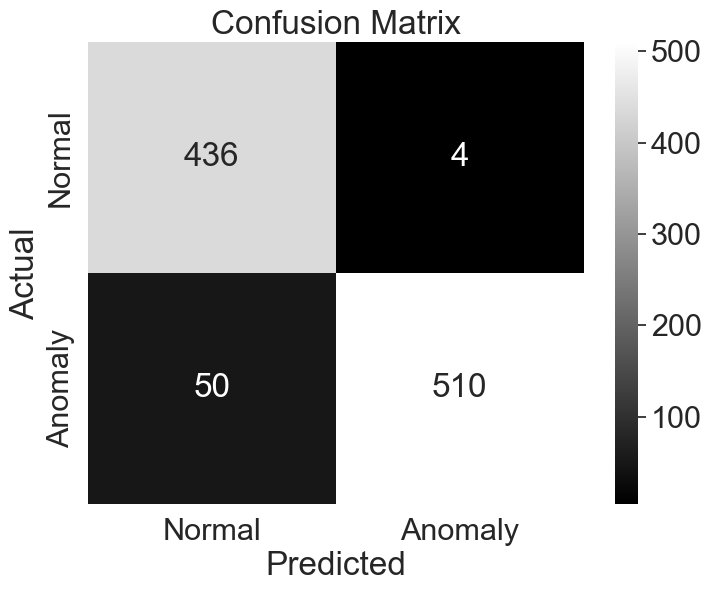

In [39]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels, preds)
plt.figure(figsize=(8,6))
sns.set(font_scale=2)
sns.set_style("white")
sns.heatmap(conf_matrix, cmap='gist_yarg_r', annot=True, fmt='d', 
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()